In [92]:
import sys
sys.path.append('/home/gabriel/fingerprint-enhancement/')
sys.path.append('/home/gabriel/fingerprint-enhancement/src')


from models.enhancer_module import *
from models.components.ResUNet import *
from data.enhancer_train_datamodule import EnhancerTrainDataModule

In [93]:
batch_size  = 2
data_dir   = '/storage/gabriel/basen_train/'
data_module = EnhancerTrainDataModule(data_dir=data_dir, lat_subdir='/lat_synthetic_documents/', ref_subdir='ref_orig/', skel_subdir='ref_skel/', mask_subdir='masks_synthetic_bg/', mnt_map_subdir='ref_mnt_map/', data_list='masks_ref_list.txt', batch_size=batch_size)

data_module.setup()
x, labels = next(iter(data_module.train_dataloader()))


In [94]:
labels[0].shape

torch.Size([4, 512, 512])

In [95]:
x.shape

torch.Size([2, 1, 512, 512])

## visualize orig, skel, mask and mnt_map labels

In [96]:
orig, skel, mask, mnt_map = labels[:,0,:,:],  labels[:,1,:,:],  labels[:,2,:,:],  labels[:,3,:,:]

In [97]:
mnt_map[0].shape

torch.Size([512, 512])

Text(0.5, 1.0, 'Minutiae Map')

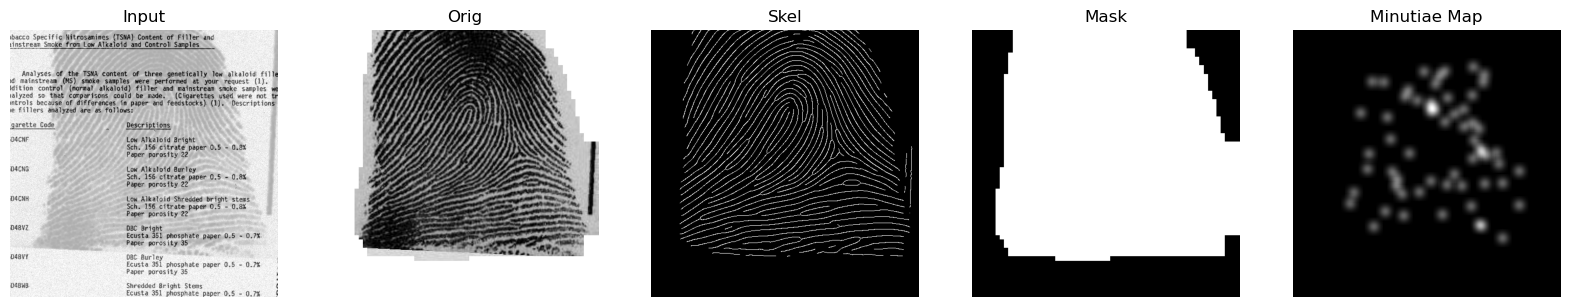

In [98]:

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 5)
ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(orig[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Orig')

ax[2].imshow(skel[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Skel')

ax[3].imshow(mask[0], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Mask')

ax[4].imshow(mnt_map[0], cmap = 'gray')
ax[4].axis('off')
ax[4].set_title('Minutiae Map')

torch.Size([2, 1, 512, 512])


Text(0.5, 1.0, 'Ground-truth Minutiae')

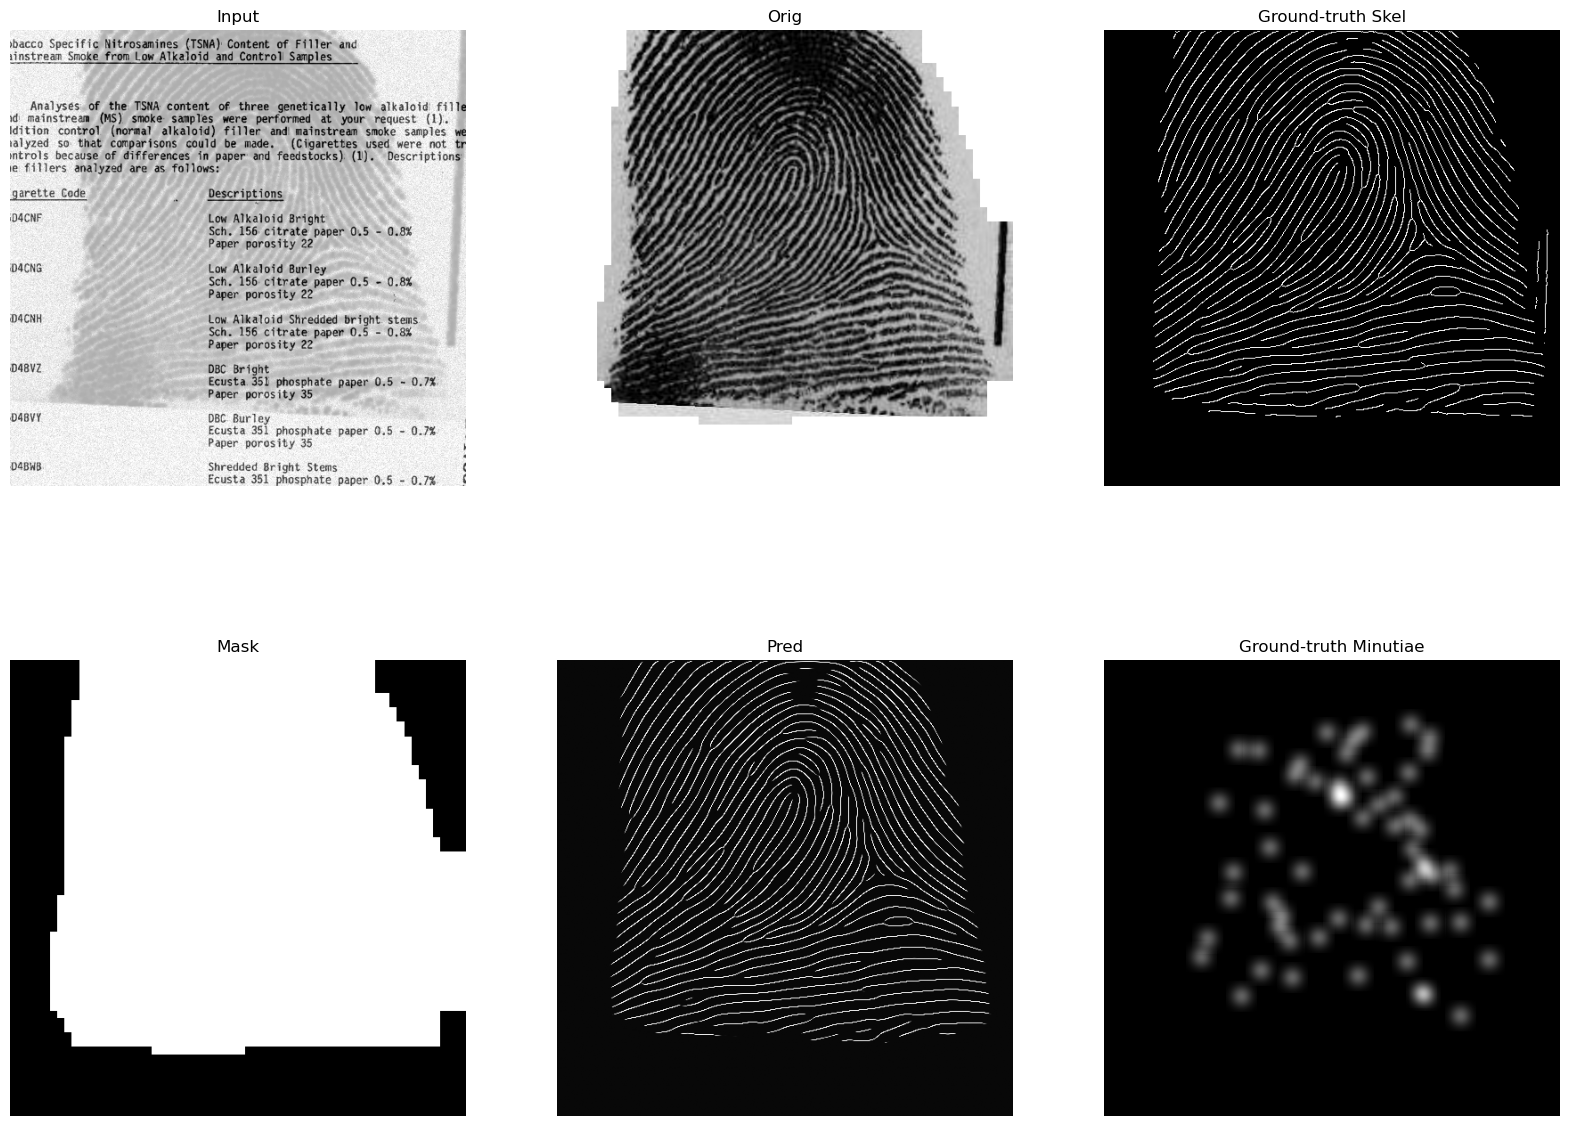

In [99]:
from data.enhancer_predict_datamodule import *

model_path = '/home/gabriel/fingerprint-enhancement/logs/train/runs/2025-05-18_04-36-05/checkpoints/last.ckpt'
model      = EnhancerLitModule.load_from_checkpoint(model_path)

device = 'cpu'

model = model.to(device)
x     = x.to(device)
with torch.no_grad():
    model.eval()
    # enh, mask, mnts, orifield = model.forward(x)
    enh = model.forward(x)

print(enh.shape)

fig, ax = plt.subplots(figsize = (20,15), nrows=2, ncols = 3)
ax[0][0].imshow(x[0][0], cmap = 'gray')
ax[0][0].axis('off')
ax[0][0].set_title('Input')

ax[0][1].imshow(orig[0], cmap = 'gray')
ax[0][1].axis('off')
ax[0][1].set_title('Orig')

ax[0][2].imshow(skel[0], cmap = 'gray')
ax[0][2].axis('off')
ax[0][2].set_title('Ground-truth Skel')

ax[1][0].imshow(mask[0], cmap = 'gray')
ax[1][0].axis('off')
ax[1][0].set_title('Mask')

ax[1][1].imshow(enh[0][0], cmap = 'gray')
ax[1][1].axis('off')
ax[1][1].set_title('Pred')

ax[1][2].imshow(mnt_map[0], cmap = 'gray')
ax[1][2].axis('off')
ax[1][2].set_title('Ground-truth Minutiae')

torch.Size([2, 512, 512])
Simple loss:  tensor(0.0341)
Weighted loss:  tensor(0.0022)
Mean over mask loss:  tensor(0.0586)
Old loss:  tensor(583.2136)


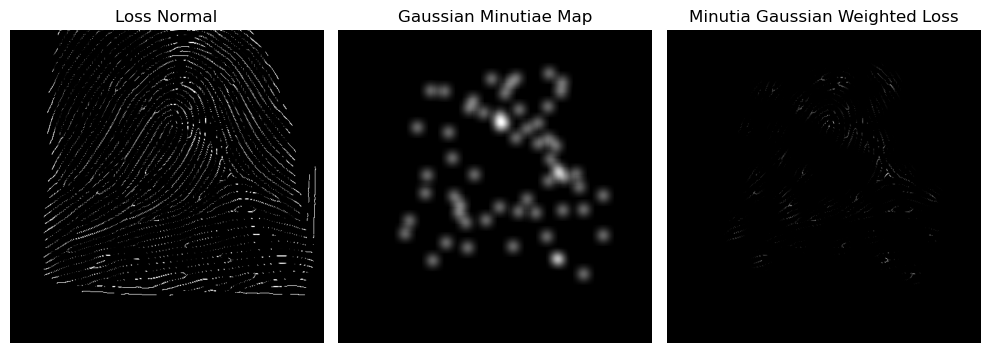

In [106]:
class MyWeightedL1Loss(nn.L1Loss):
    def __init__(self, reduction='none'):
        super(MyWeightedL1Loss, self).__init__(reduction=reduction)

    def forward(self, input, target, pixel_weight):
        pixel_mae = super(MyWeightedL1Loss, self).forward(input, target)
        loss = pixel_mae * pixel_weight
        print(loss.shape)
        return loss.sum()/(loss.size(0)) # mean per-image loss (not per-pixel or per-batch).


loss_map           = torch.nn.functional.l1_loss(enh[:,0,:,:], skel, reduction = 'none')
# minutia_weight_map =  extract_mcc_cpu(mnts_label, img.shape, 12, 5.0)
# minutia_weight_map.shape
# minutia_weight_map = (minutia_weight_map - torch.min(minutia_weight_map)) / (torch.max(minutia_weight_map) - torch.min(minutia_weight_map))

criterion = MyWeightedL1Loss()

simple_loss   = torch.mean(loss_map)
weighted_loss = torch.mean(loss_map * mnt_map)

old_loss = criterion(enh[:,0,:,:], skel, mnt_map)

mean_mask_loss = torch.mean(torch.sum(loss_map * mnt_map, dim=(1,2)) / (torch.sum(mnt_map, dim=(1,2)) + 1e-7) )


print("Simple loss: ", simple_loss)
print("Weighted loss: ", weighted_loss)
print("Mean over mask loss: ", mean_mask_loss)
print("Old loss: ", old_loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 3)
ax[0].imshow((loss_map)[0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Loss Normal")
ax[1].imshow(mnt_map[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Gaussian Minutiae Map")
ax[2].imshow((loss_map * mnt_map)[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Minutia Gaussian Weighted Loss")


fig.tight_layout()
plt.show()

In [101]:
mean_mask_loss.shape

torch.Size([])

In [102]:
loss_map.shape

torch.Size([2, 512, 512])

In [103]:
enh.shape

torch.Size([2, 1, 512, 512])

In [104]:
mnt_map.shape

torch.Size([2, 512, 512])